## Downloading The Dataset

In this section, dataset will be downloaded and opened as a pandas dataframe


In [118]:
from Bio import Entrez
import pandas as pd
from io import StringIO
from Bio import SeqIO
import numpy as np
import biovec
import gensim
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import tanglegram as tg

In [119]:
def get_taxid_by_name(organism_name): # gets taxid from organism name using Entrez
    Entrez.email = "n@mail.com"

    search_handle = Entrez.esearch(db="taxonomy", term=organism_name)
    search_results = Entrez.read(search_handle)

    if len(search_results["IdList"]) == 0:
        print(f"No results found for {organism_name}")
        return 0

    # Get the taxid from the search results
    taxid = search_results["IdList"][0]

    return taxid

In [156]:
Acidobacteriota = "Acidobateriota.tsv"
base_df = pd.read_csv(Acidobacteriota, sep="\t")

In [121]:
df = base_df.dropna(subset=["Annotation Name"])
df = df[df["Annotation Name"].str.contains('NCBI Prokaryotic Genome Annotation Pipeline')] # only organisms from NCBI pipeline
df = df[~df["Organism Name"].str.contains("Candidatus")] # to remove candidate organisms
df = df[~df["Organism Name"].str.contains("Candidate")]
df = df[~df["Organism Name"].str.contains("uncultered")]
df = df.drop_duplicates(subset=["Organism Name"]) # to remove duplicates

In [122]:
df["taxid"] = df["Organism Name"].apply(get_taxid_by_name)

In [123]:
def get_nucleotide_sequence_by_taxid(taxid, num_records=1): # gets nucleotide sequence from taxid using Entrez
    try:
        search_handle = Entrez.esearch(db="nuccore", term=f"txid{taxid}[Organism:exp]", retmax=num_records)
        search_results = Entrez.read(search_handle)
        nuccore_uids = search_results["IdList"]
        fetch_handle = Entrez.efetch(db="nuccore", id=nuccore_uids, rettype="fasta", retmode="text")
        nucleotide_records = fetch_handle.read()
    
        return str(SeqIO.read(StringIO(nucleotide_records), "fasta").seq)
    except:
        return 0

In [124]:
df["sequence"] = df["taxid"].apply(get_nucleotide_sequence_by_taxid)
df.drop(df[df["sequence"] == 0].index, inplace=True) # to remove organisms with no sequence

In [125]:
df.reset_index(drop=True, inplace=True)

# ProtVec

In [126]:
def df_to_fasta(df, fasta_file): # to create a fatsa file to train protvec
    with open(fasta_file, "w") as f:
        for index, row in df.iterrows():
            f.write(f">{row['Assembly Accession']}\n{row['sequence']}\n")

In [127]:
df_to_fasta(df, "Acidobacteriota.fasta")

In [128]:
pv = biovec.models.ProtVec('Acidobacteriota.fasta')

Generate Corpus file from fasta file...


corpus generation progress: 100%|██████████| 51/51 [00:14<00:00,  3.58it/s]


In [129]:
def get_protvec_vectors(seq, pv,vector):
    return pv.to_vecs(seq)[vector].flatten()

In [130]:
df["protvec_0"] = df["sequence"].apply(get_protvec_vectors, pv=pv, vector=0)
df["protvec_1"] = df["sequence"].apply(get_protvec_vectors, pv=pv, vector=1)
df["protvec_2"] = df["sequence"].apply(get_protvec_vectors, pv=pv, vector=2)

# Word2Vec

In [131]:
def split_string_into_thirds(input_string):
    return [input_string[i:i+3] for i in range(0, len(input_string), 3)]

def get_word2vec_skipgram(seq):
    try:
        return gensim.models.Word2Vec(split_string_into_thirds(seq), min_count=3, size=100, sg=1).wv.vectors.flatten()
    except:
        return np.zeros(300)
def get_word2vec_cbow(seq):
    try:
        return gensim.models.Word2Vec(split_string_into_thirds(seq), min_count=3, size=100, sg=0).wv.vectors.flatten()
    except:
        return np.zeros(300)

In [132]:
df["word2vec_skipgram"] = df["sequence"].apply(get_word2vec_skipgram)
df["word2vec_cbow"] = df["sequence"].apply(get_word2vec_cbow)


# Control DataFrame

In [133]:
df.set_index("Organism Name", inplace=True)

In [134]:
def get_lineage(taxid):
    try:
        handle = Entrez.efetch(db="Taxonomy", id=taxid, retmode="xml")
        records = Entrez.read(handle)
        lineage = records[0]["Lineage"] 
        return lineage
    except:
        return 0

In [135]:
control_df = df.copy()
control_df["lineage"] = control_df["taxid"].apply(get_lineage) # control dataframe
control_df['Domain'] = control_df.lineage.str.split(';',expand=True)[0]
control_df['Phylum'] = control_df.lineage.str.split(';',expand=True)[1]
control_df['Class'] = control_df.lineage.str.split(';',expand=True)[2]
control_df['Order'] = control_df.lineage.str.split(';',expand=True)[3]
control_df['Family'] = control_df.lineage.str.split(';',expand=True)[4]
control_df['Genus'] = control_df.lineage.str.split(';',expand=True)[5]
control_df['Species'] = control_df.lineage.str.split(';',expand=True)[6]
control_df.drop(['lineage',"Domain", "Phylum","Class","Assembly Accession","Assembly Name","Annotation Name","Annotation Count Gene Total","Annotation Count Gene Protein-coding","taxid","sequence",
                 "protvec_0","protvec_1","protvec_2","word2vec_skipgram", "word2vec_cbow"], axis=1, inplace=True)
control_df.fillna(value=np.nan, inplace=True)

In [136]:
def map_to_numeric(series):
    unique_values = series.unique()
    mapping = {value: i for i, value in enumerate(unique_values)}
    return series.map(mapping)

control_df_numeric = control_df.apply(map_to_numeric) # transforming control_df to a numeric dataframe, inorder to use it in linkage

# Dendrograms

In [161]:

def vector_dataframe(dataframe, vectors): #dataframe of vectors
    return pd.DataFrame([x for x in dataframe[vectors]], index= dataframe.index).dropna(axis=1)

def similarity(vector_df): # cosine similarity matrix
    return cosine_similarity(vector_df)

def get_linkage(dataframe, vectors): #linkage matrix
    return linkage(similarity(vector_dataframe(dataframe,vectors)), 'ward')

def print_dendrogram(dataframe,vectors,title= "No Title"): # dendogram
    plt.figure(figsize=(20,10))
    plt.title(title)
    Z = get_linkage(dataframe, vectors)
    vector_df = vector_dataframe(dataframe, vectors)
    dend =dendrogram(Z, leaf_rotation=180, leaf_font_size=2,labels=vector_df.index)
    plt.xticks(rotation = 90, fontsize = 7.5)
    plt.ylabel('Distance')
    plt.xlabel('Species')
    plt.figure(figsize=(20,10))
    
    plt.show()
    return dend

In [138]:
linkage_control = linkage(control_df_numeric, method = 'ward')
linkage_0 = get_linkage(df, "protvec_0")
linkage_1 = get_linkage(df, "protvec_1")
linkage_2 = get_linkage(df, "protvec_2")
linkage_skipgram = get_linkage(df, "word2vec_skipgram")
linkage_cbow = get_linkage(df, "word2vec_cbow")

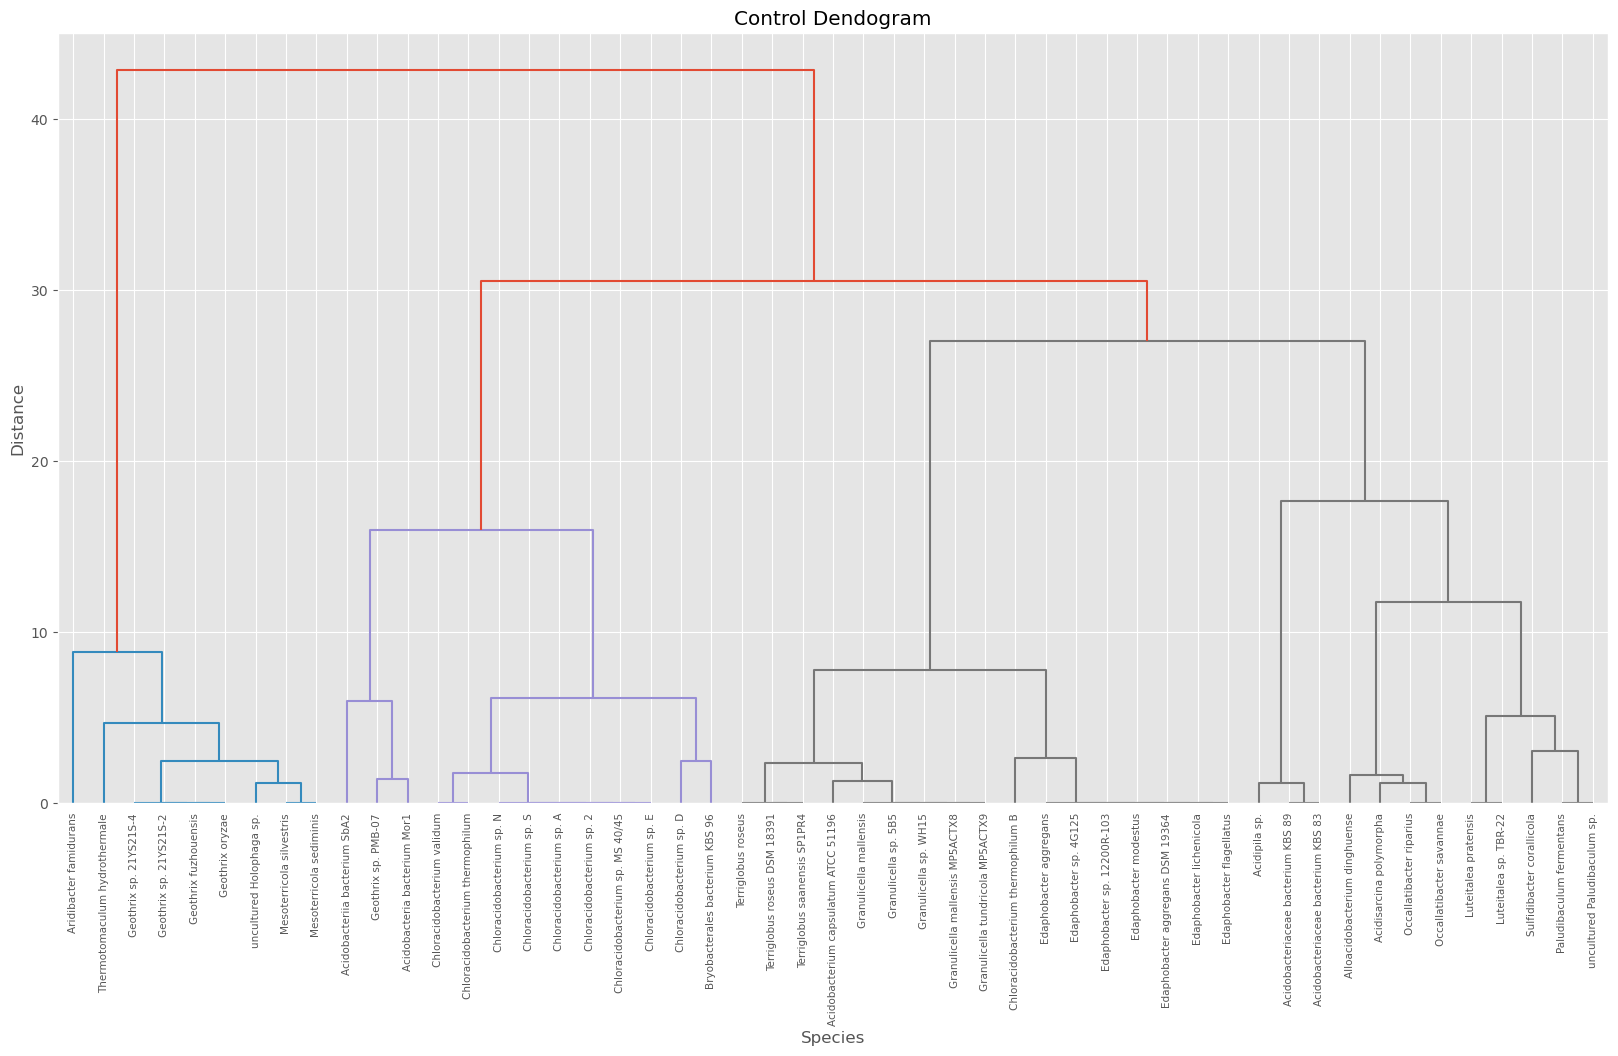

<Figure size 2000x1000 with 0 Axes>

In [160]:
plt.figure(figsize=(20,10))
dend_control = dendrogram(linkage_control, leaf_rotation=180, leaf_font_size=2,labels=control_df.index)
plt.xticks(rotation= 90, fontsize = 7.5)
plt.title("Control Dendogram")
plt.ylabel('Distance')
plt.xlabel('Species')
plt.figure(figsize=(20,10))
plt.show()

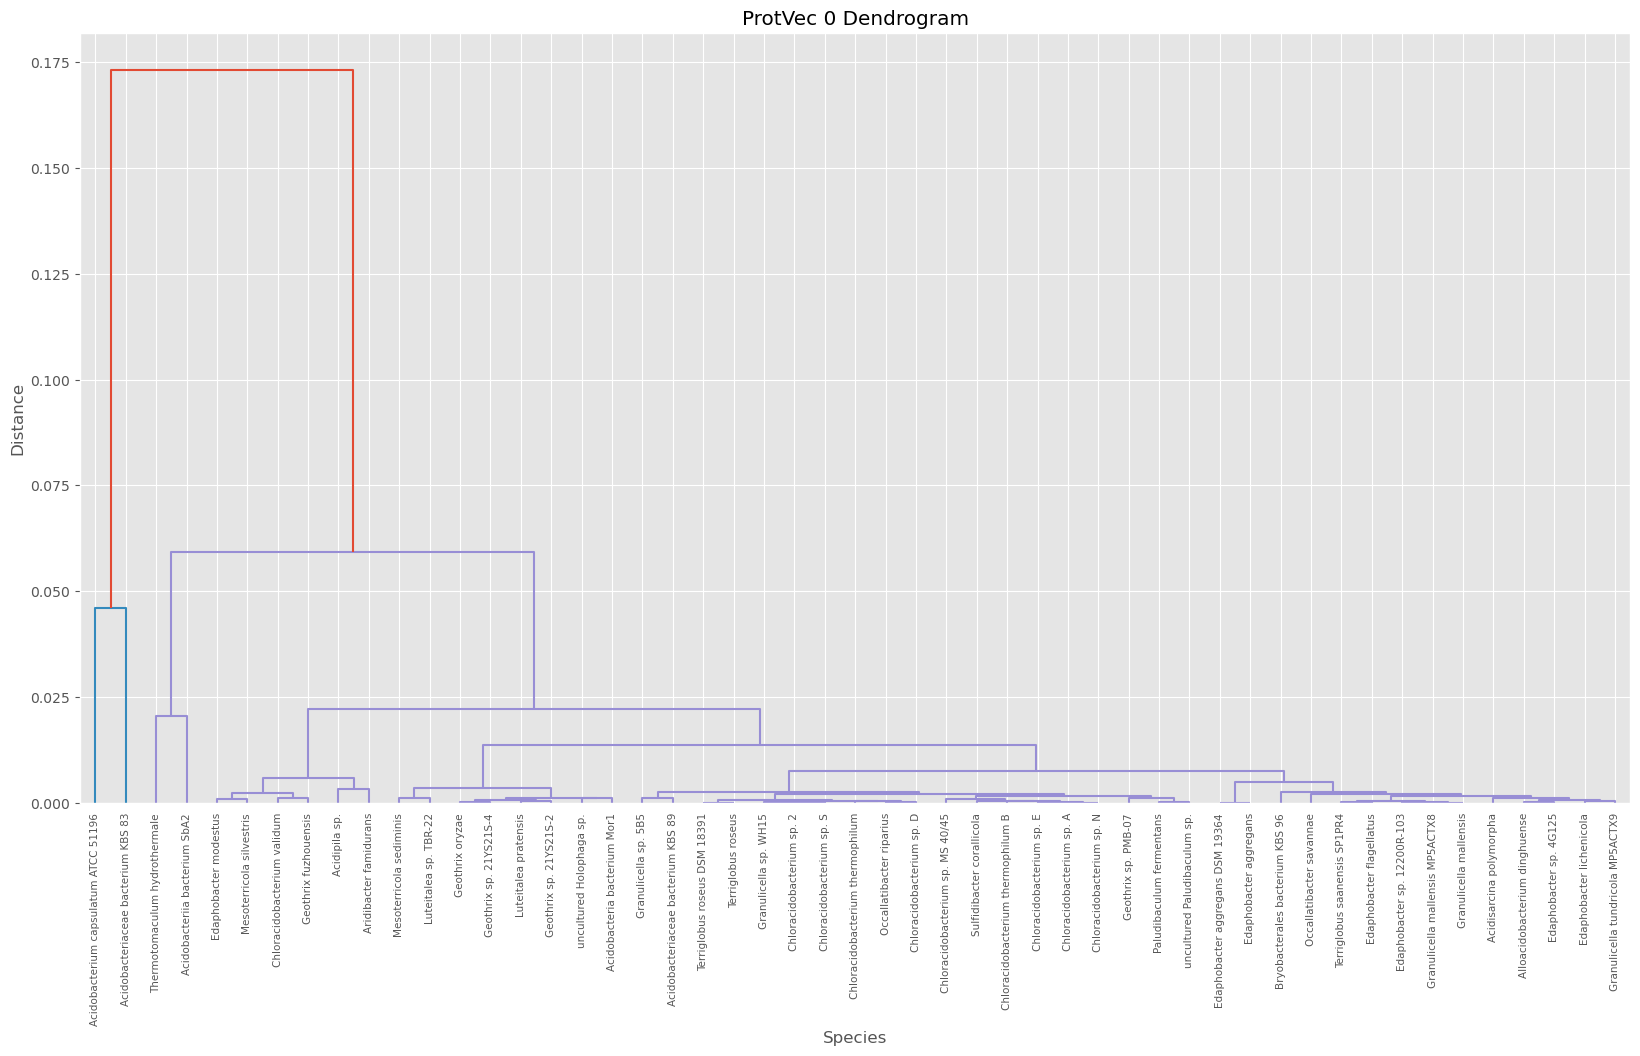

<Figure size 2000x1000 with 0 Axes>

In [162]:
dend_0 = print_dendrogram(df, "protvec_0", title="ProtVec 0 Dendrogram")

In [159]:
control_df.nunique()


Order       5
Family     10
Genus      11
Species    17
dtype: int64

In [172]:
control_df

Order  \
Organism Name                                                           
Acidobacterium capsulatum ATCC 51196                      Terriglobia   
Granulicella mallensis MP5ACTX8                           Terriglobia   
Terriglobus roseus DSM 18391                              Terriglobia   
Chloracidobacterium thermophilum B                     Blastocatellia   
Edaphobacter lichenicola                                  Terriglobia   
Terriglobus saanensis SP1PR4                              Terriglobia   
Granulicella tundricola MP5ACTX9                          Terriglobia   
Sulfidibacter corallicola                                  Holophagae   
Paludibaculum fermentans                                  Terriglobia   
Luteitalea pratensis                                 Vicinamibacteria   
Acidisarcina polymorpha                                   Terriglobia   
Occallatibacter riparius                                  Terriglobia   
Alloacidobacterium dinghuense                             Terriglobia   
Edaphobacter flagellatus                                  Terriglobia   
Thermotomaculum hydrothermale                              Holophagae   
Chloracidobacterium sp. MS 40/45                       Blastocatellia   
Chloracidobacterium validum                            Blastocatellia   
Edaphobacter aggregans DSM 19364                          Terriglobia   
Edaphobacter modestus                                     Terriglobia   
Geothrix fuzhouensis                                       Holophagae   
Occallatibacter savannae                                  Terriglobia   
Chloracidobacterium thermophilum                       Blastocatellia   
Mesoterricola silvestris                                   Holophagae   
Mesoterricola sediminis                                    Holophagae   
Geothrix oryzae                                            Holophagae   
Granulicella sp. WH15                                     Terriglobia   
Luteitalea sp. TBR-22                                Vicinamibacteria   
Geothrix sp. 21YS21S-2                                     Holophagae   
Edaphobacter sp. 12200R-103                               Terriglobia   
Edaphobacter sp. 4G125                                    Terriglobia   
Geothrix sp. PMB-07                                               NaN   
Granulicella sp. 5B5                                      Terriglobia   
Geothrix sp. 21YS21S-4                                     Holophagae   
Chloracidobacterium sp. E                              Blastocatellia   
Chloracidobacterium sp. 2                              Blastocatellia   
Chloracidobacterium sp. A                              Blastocatellia   
Chloracidobacterium sp. S                              Blastocatellia   
Chloracidobacterium sp. D                              Blastocatellia   
Chloracidobacterium sp. N                              Blastocatellia   
Terriglobus roseus                                        Terriglobia   
Granulicella mallensis                                    Terriglobia   
Edaphobacter aggregans                                    Terriglobia   
uncultured Holophaga sp.                                   Holophagae   
uncultured Paludibaculum sp.                              Terriglobia   
Acidobacteria bacterium Mor1           Acidobacteriota incertae sedis   
Bryobacterales bacterium KBS 96                           Terriglobia   
Acidobacteriaceae bacterium KBS 89                        Terriglobia   
Acidobacteriaceae bacterium KBS 83                        Terriglobia   
Acidipila sp.                                             Terriglobia   
Aridibacter famidurans                                 Blastocatellia   
Acidobacteriia bacterium SbA2                             Terriglobia   

                                                               Family  \
Organism Name                                                           
Acidobacterium capsulatum ATCC 51196            

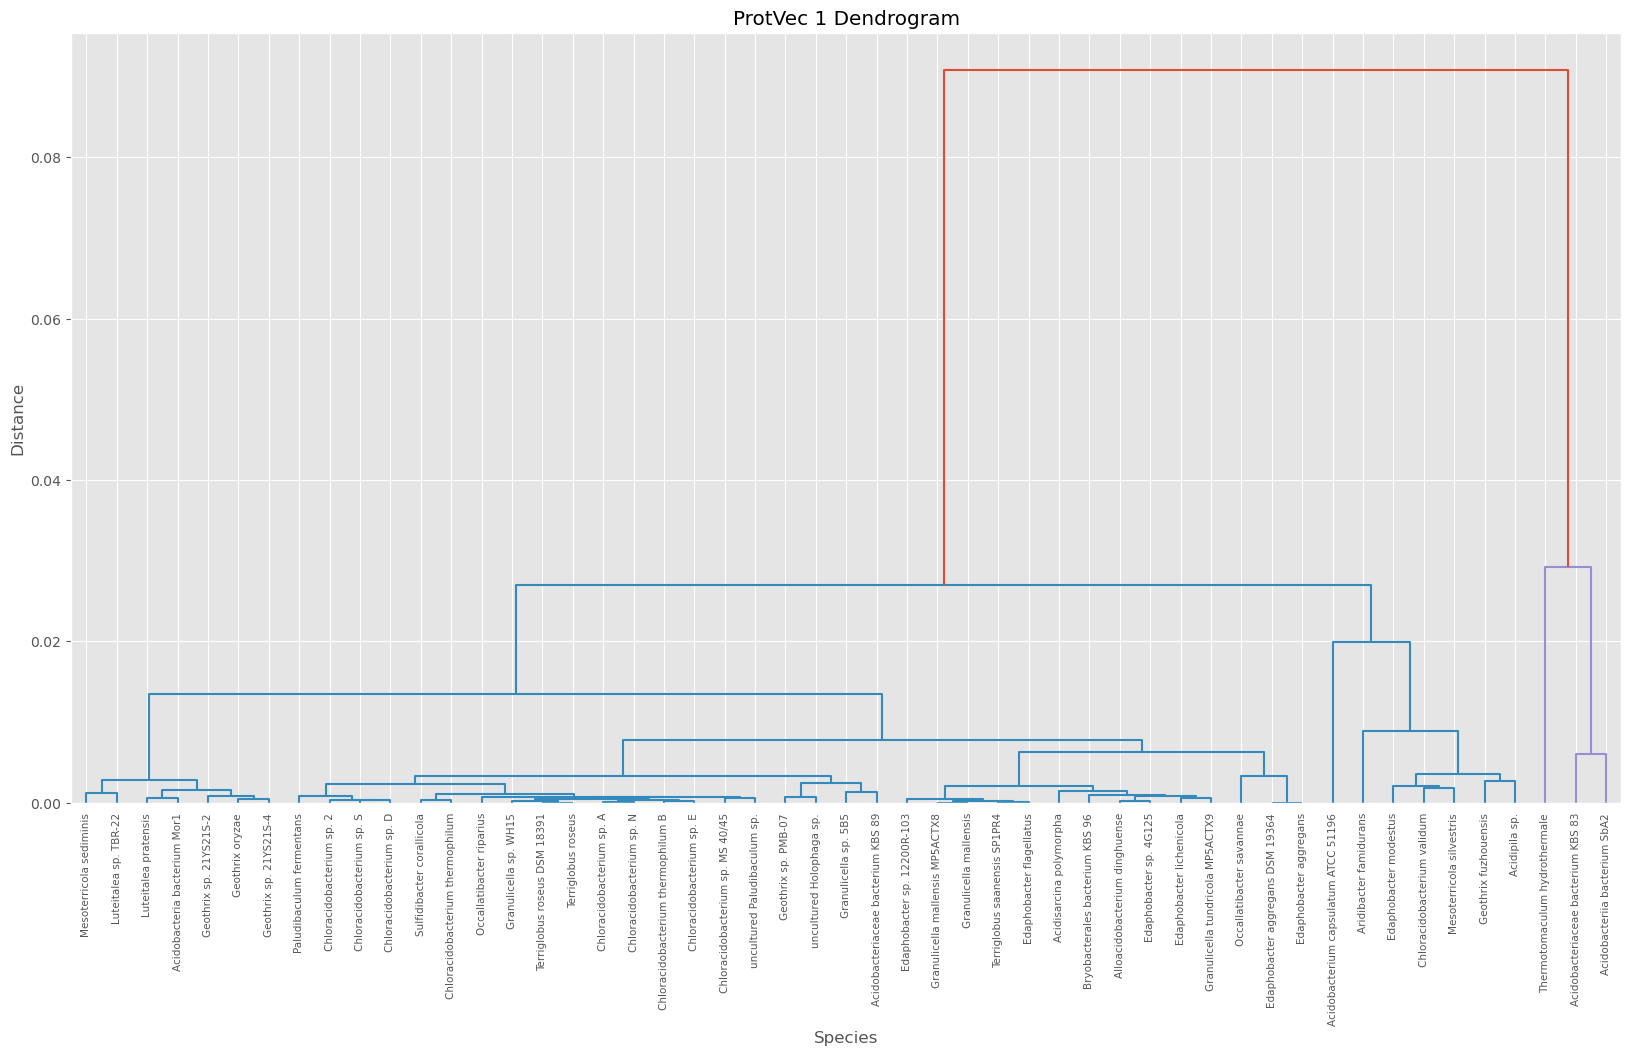

<Figure size 2000x1000 with 0 Axes>

In [163]:
dend_1= print_dendrogram(df, "protvec_1", title="ProtVec 1 Dendrogram")

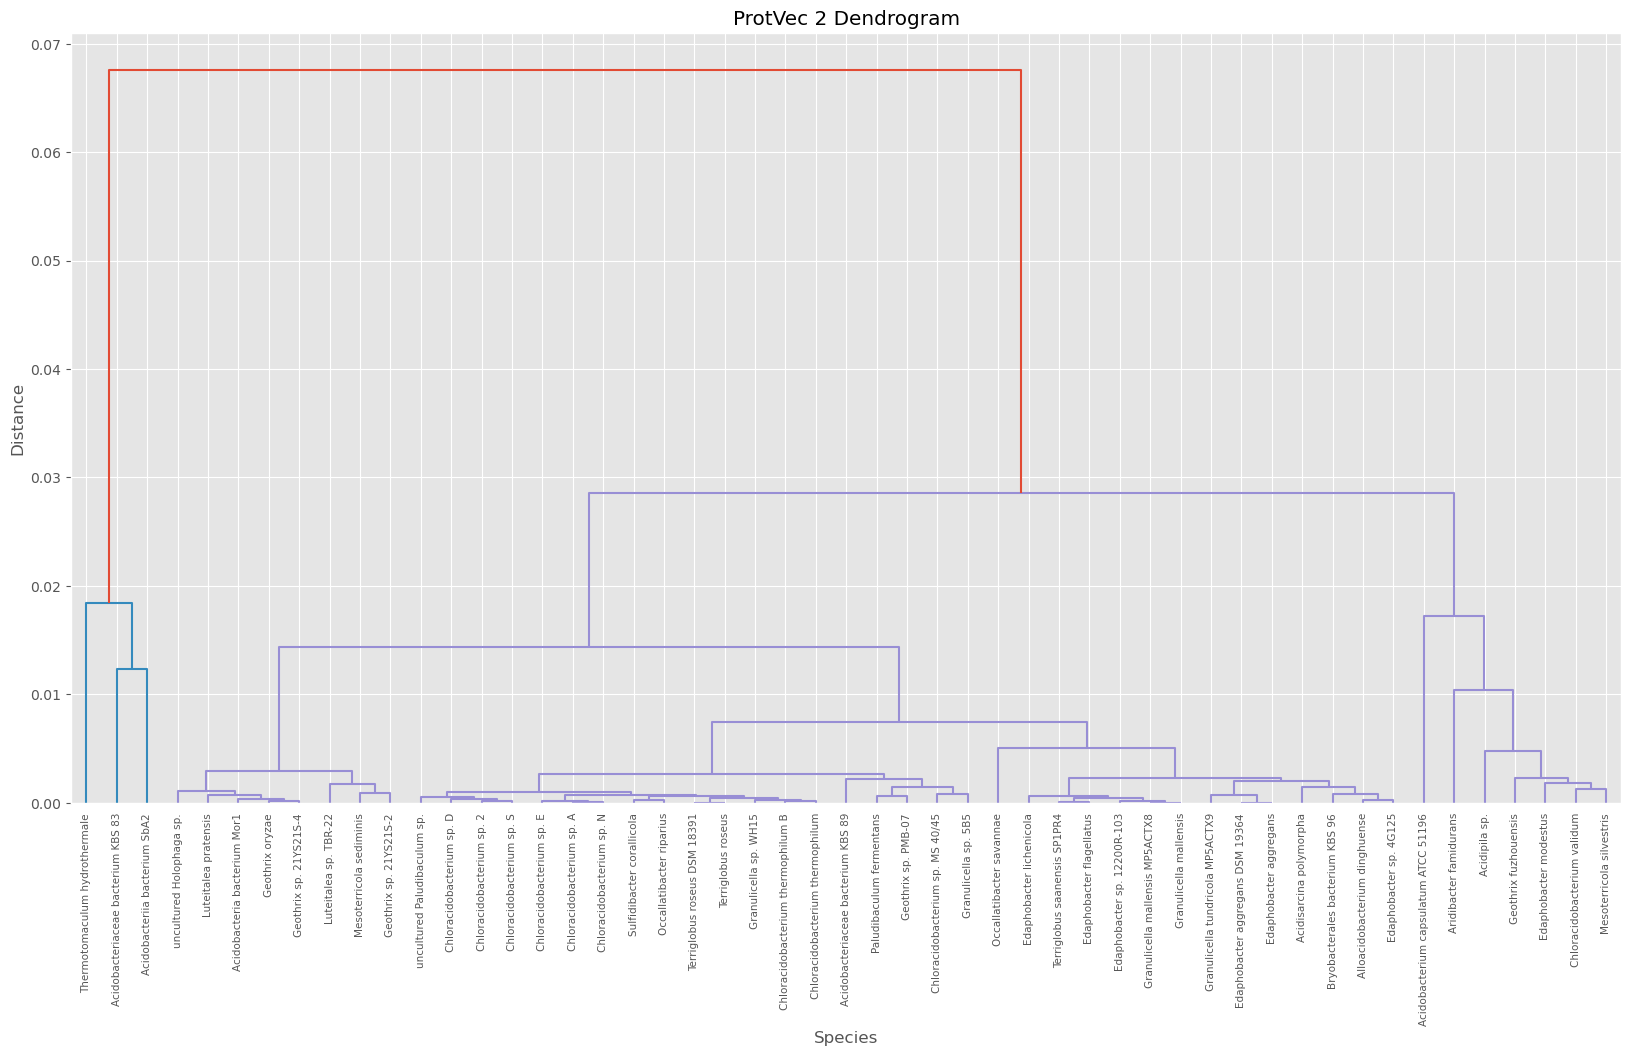

<Figure size 2000x1000 with 0 Axes>

In [164]:
dend_2 = print_dendrogram(df, "protvec_2", title="ProtVec 2 Dendrogram")

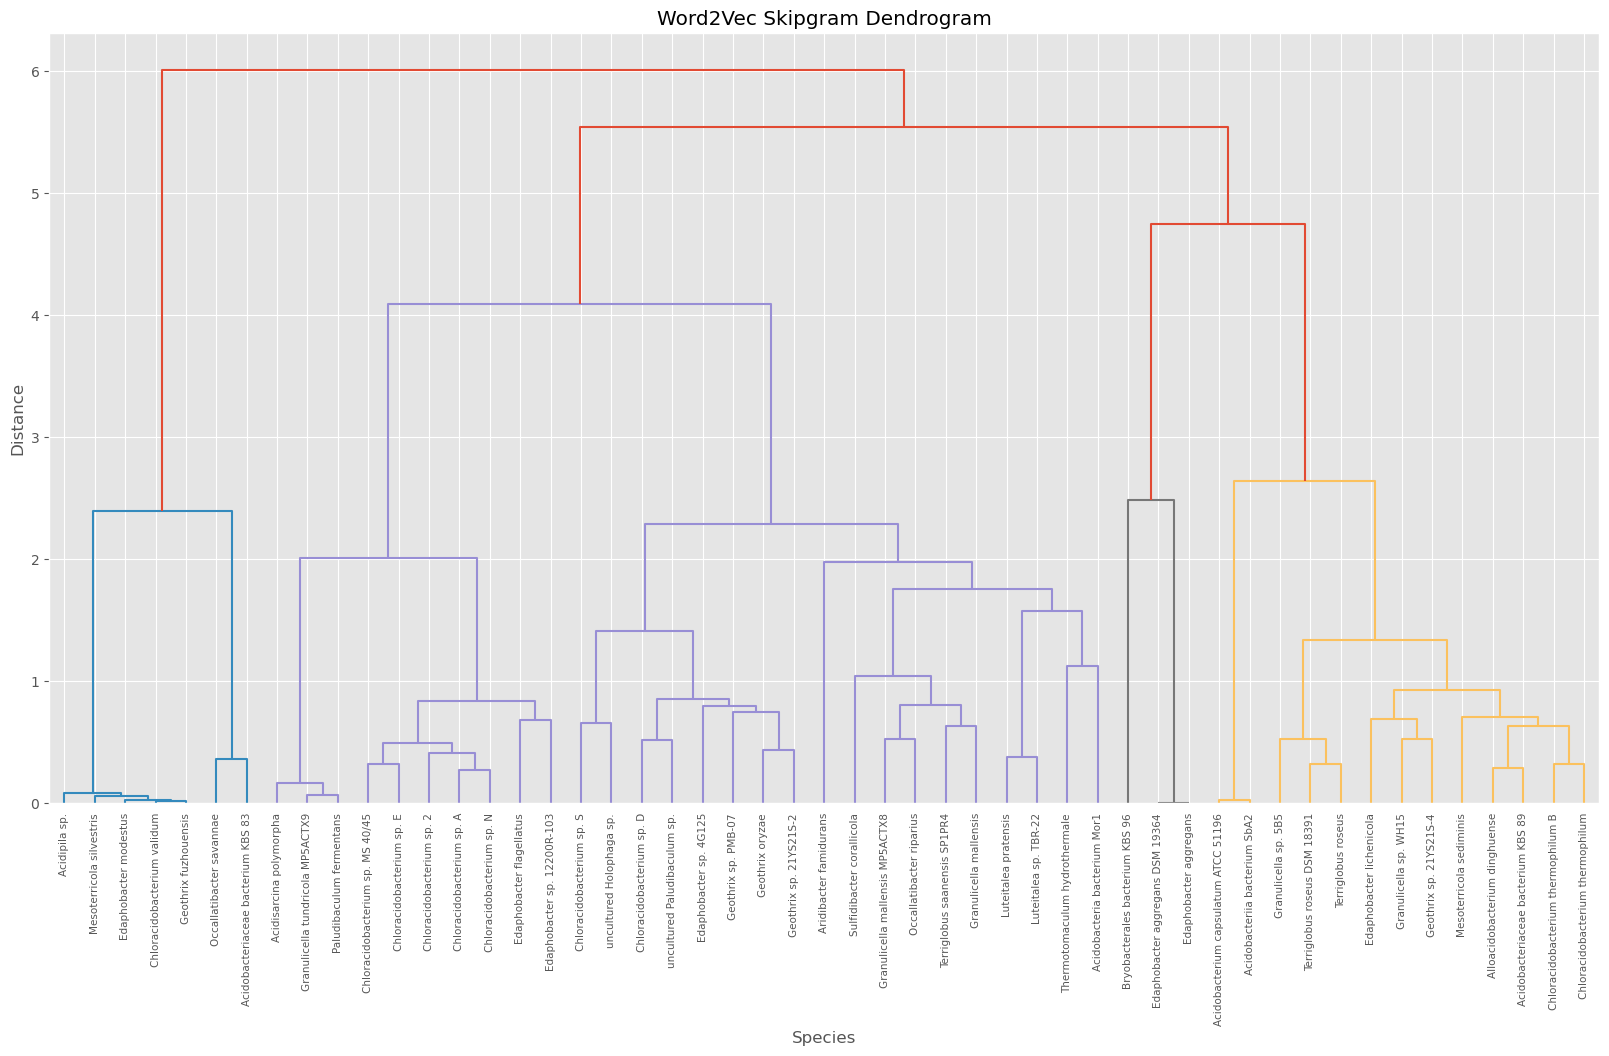

<Figure size 2000x1000 with 0 Axes>

In [166]:
dend_skipgram = print_dendrogram(df, "word2vec_skipgram", title="Word2Vec Skipgram Dendrogram")

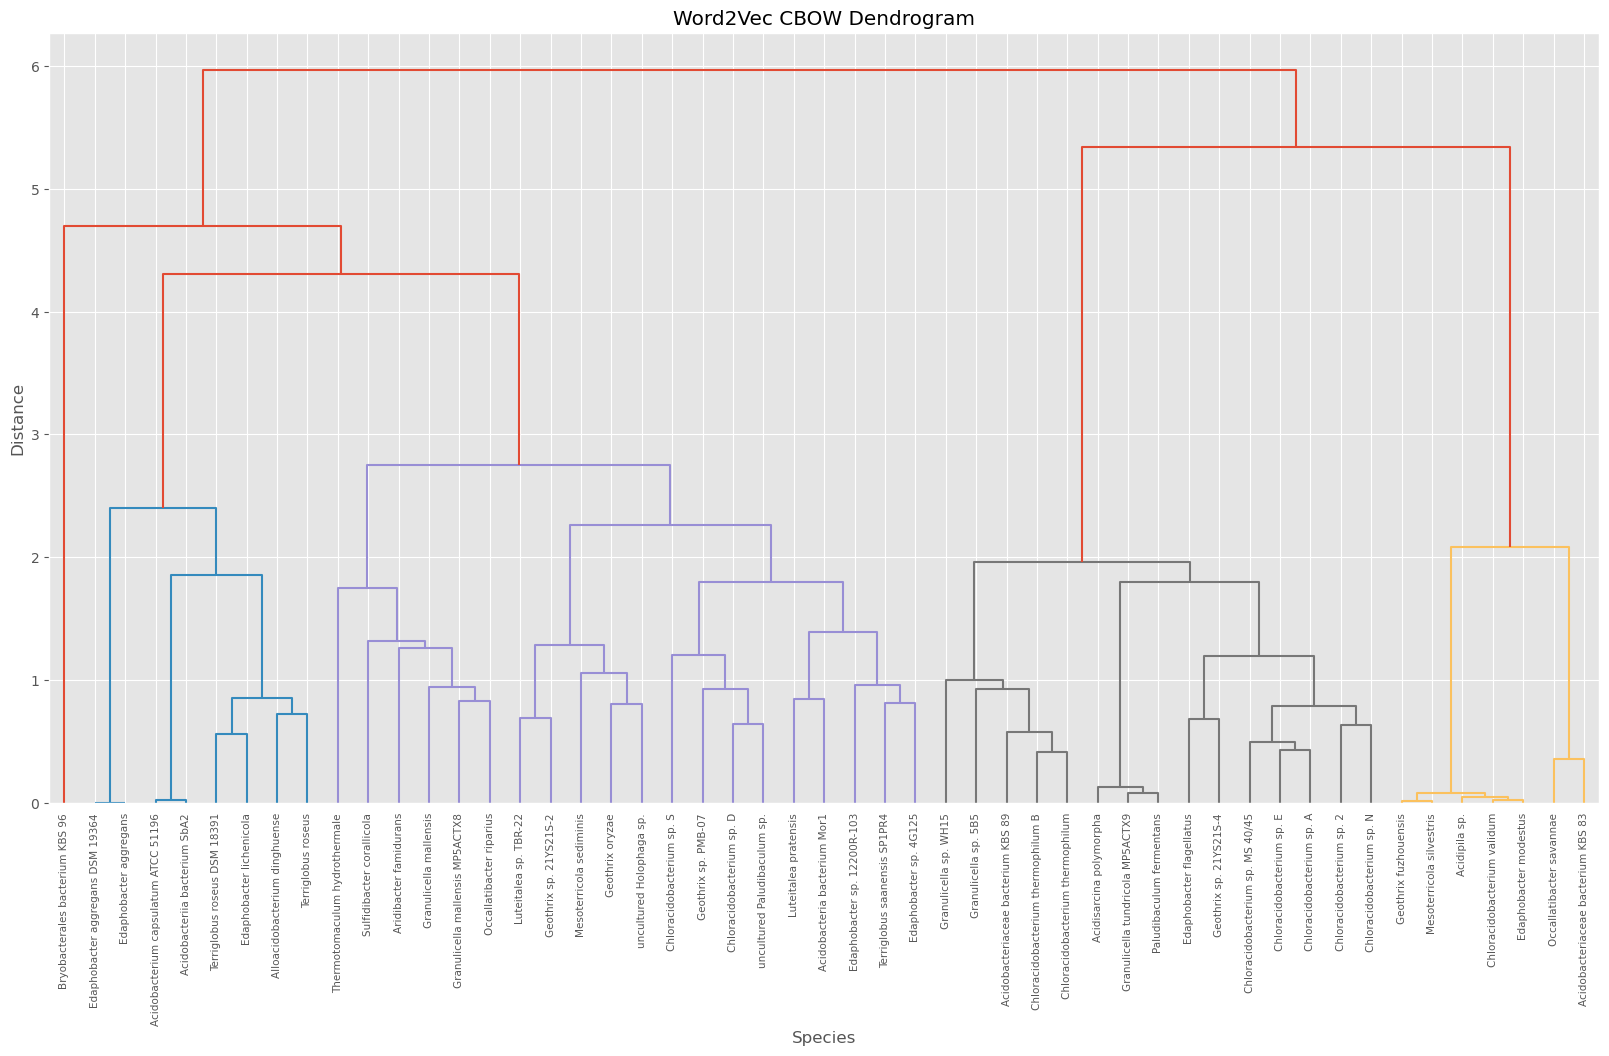

<Figure size 2000x1000 with 0 Axes>

In [165]:
dend_cbow = print_dendrogram(df, "word2vec_cbow", title="Word2Vec CBOW Dendrogram")

# Tanglegrams

In [145]:
def plot_tanglegram(l_1,l_2,index_1,index_2, title):
    tg.plot(l_1,l_2,index_1, index_2,figsize=(16,9),sort="step2side")
    plt.title(title)
    plt.show()

INFO  : Finished optimising at entanglement 0.16 (tanglegram.tangle)
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tanglegram.tangle)


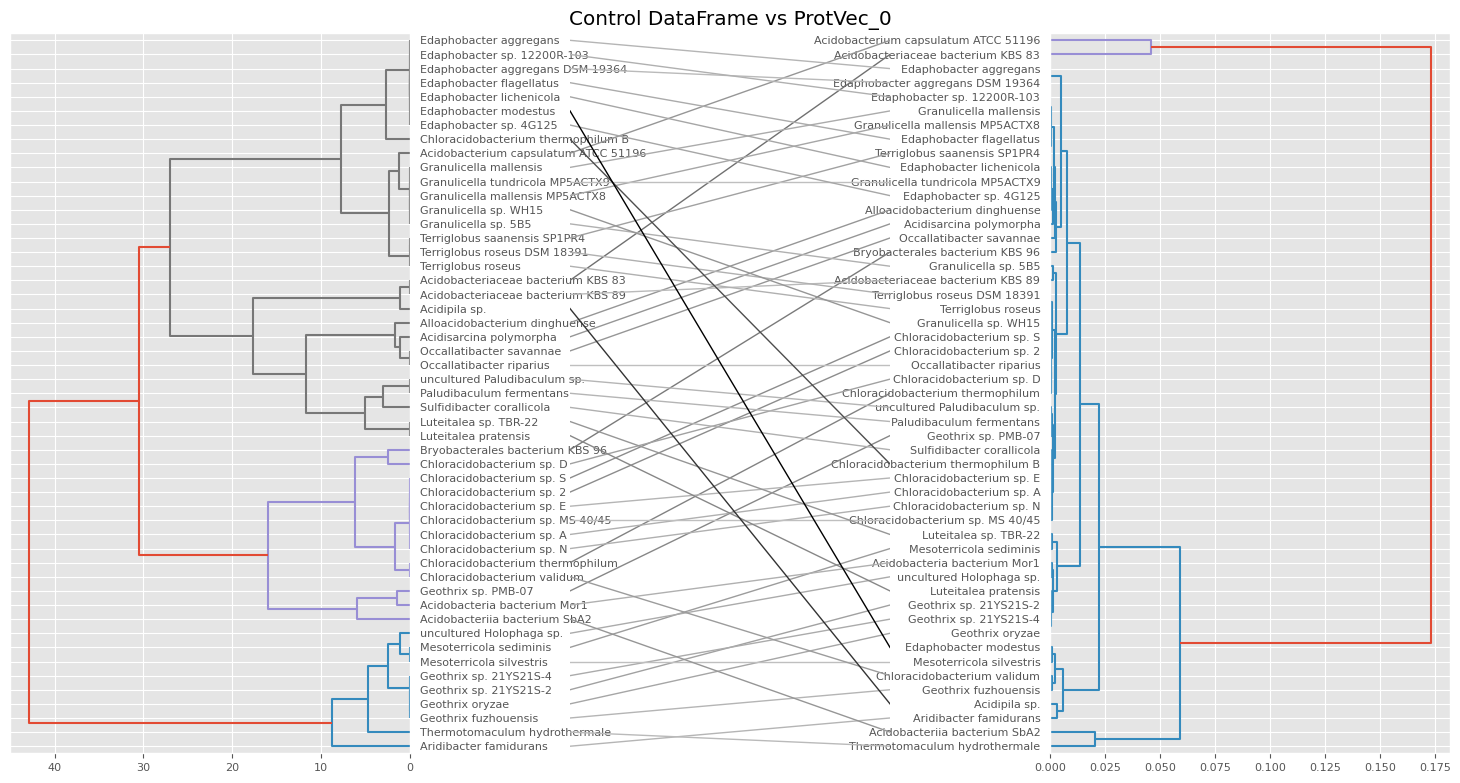

In [167]:
plot_tanglegram(linkage_control,linkage_0,control_df.index,df.index,"Control DataFrame vs ProtVec_0")

INFO  : Finished optimising at entanglement 0.19 (tanglegram.tangle)
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tanglegram.tangle)


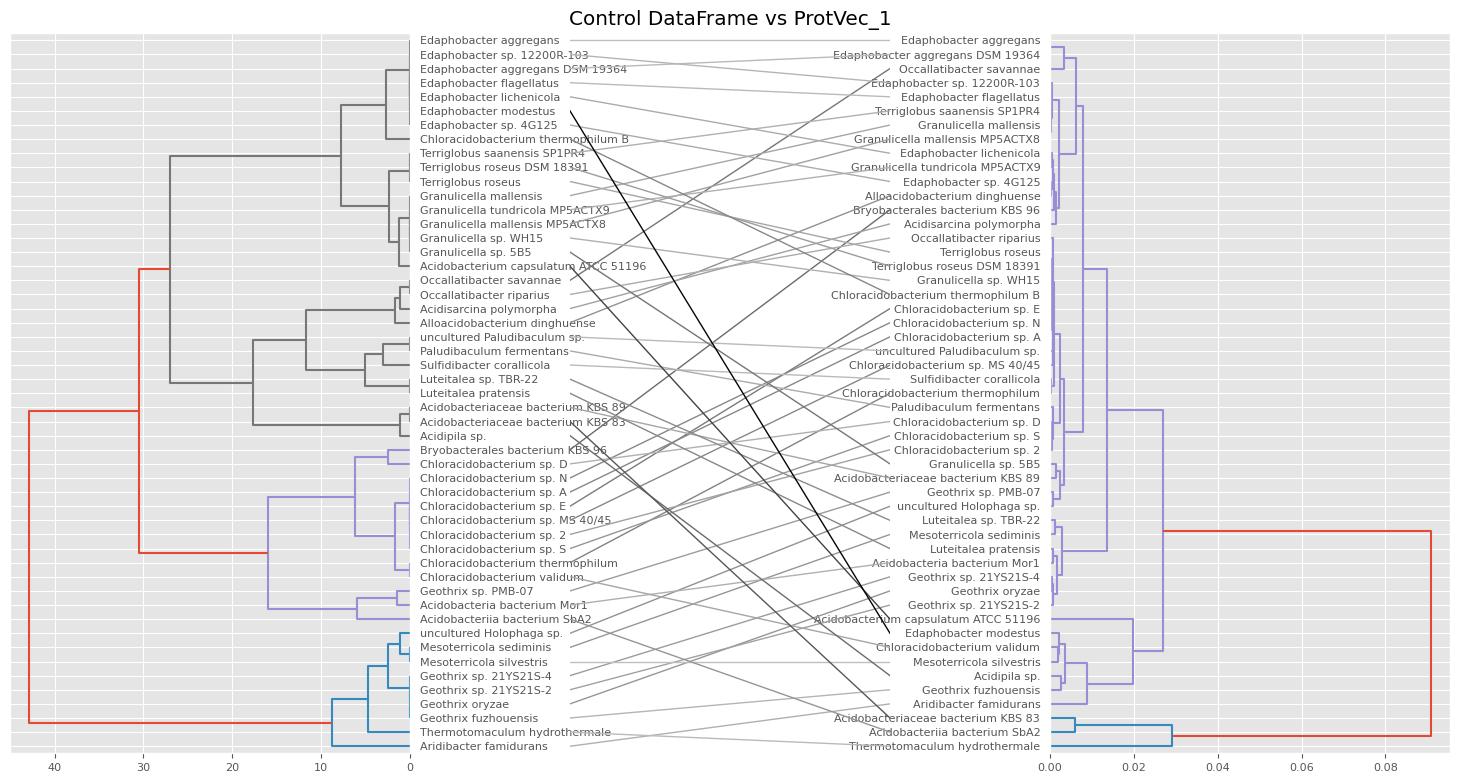

In [147]:
plot_tanglegram(linkage_control,linkage_1, control_df.index,df.index,"Control DataFrame vs ProtVec_1")

INFO  : Finished optimising at entanglement 0.16 (tanglegram.tangle)
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tanglegram.tangle)


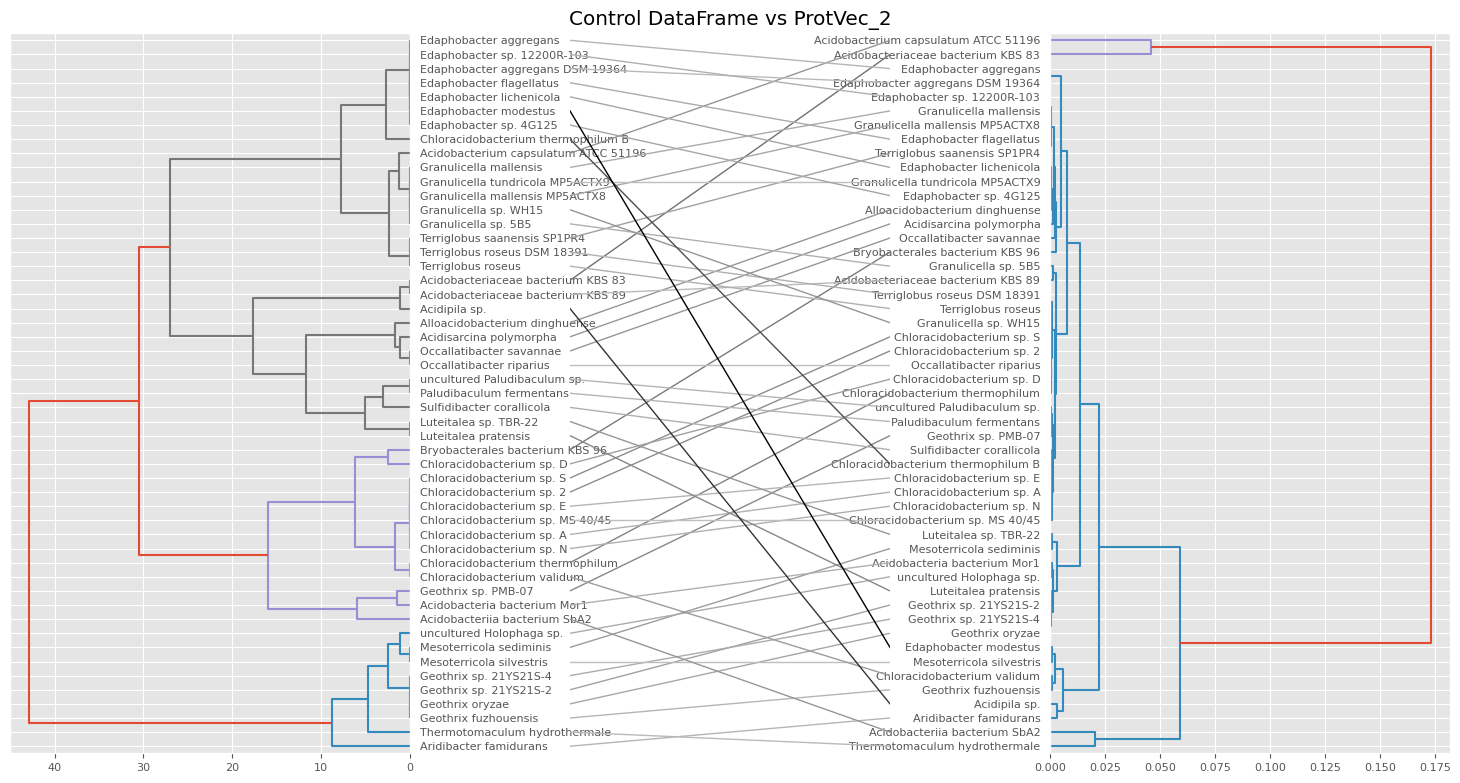

In [148]:
plot_tanglegram(linkage_control,linkage_0,control_df.index,df.index,"Control DataFrame vs ProtVec_2")

INFO  : Finished optimising at entanglement 0.33 (tanglegram.tangle)
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tanglegram.tangle)


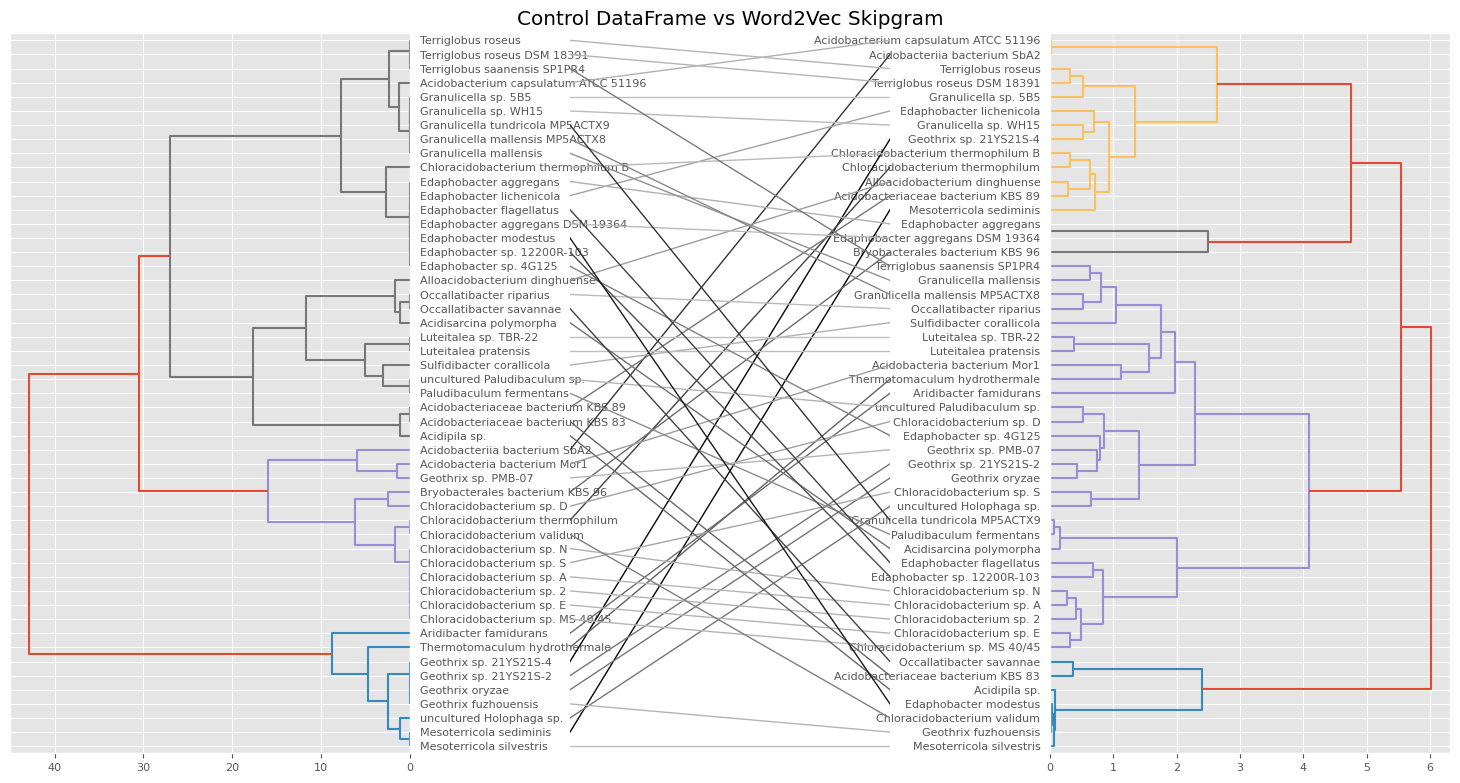

In [149]:
plot_tanglegram(linkage_control,linkage_skipgram,control_df.index,df.index,"Control DataFrame vs Word2Vec Skipgram")

INFO  : Finished optimising at entanglement 0.31 (tanglegram.tangle)
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tanglegram.tangle)


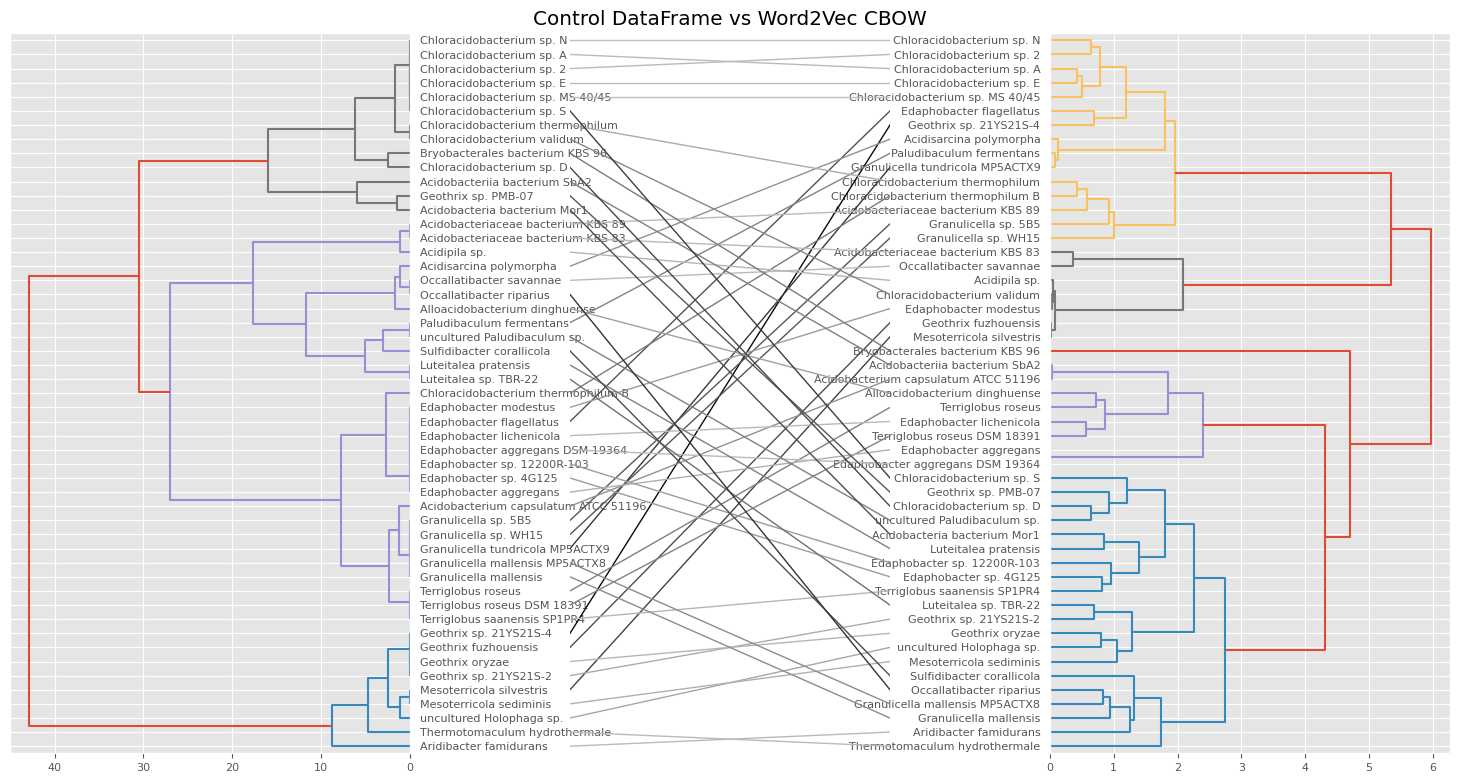

In [150]:
plot_tanglegram(linkage_control,linkage_cbow,control_df.index,df.index,"Control DataFrame vs Word2Vec CBOW")

INFO  : Finished optimising at entanglement 0.02 (tanglegram.tangle)
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tanglegram.tangle)


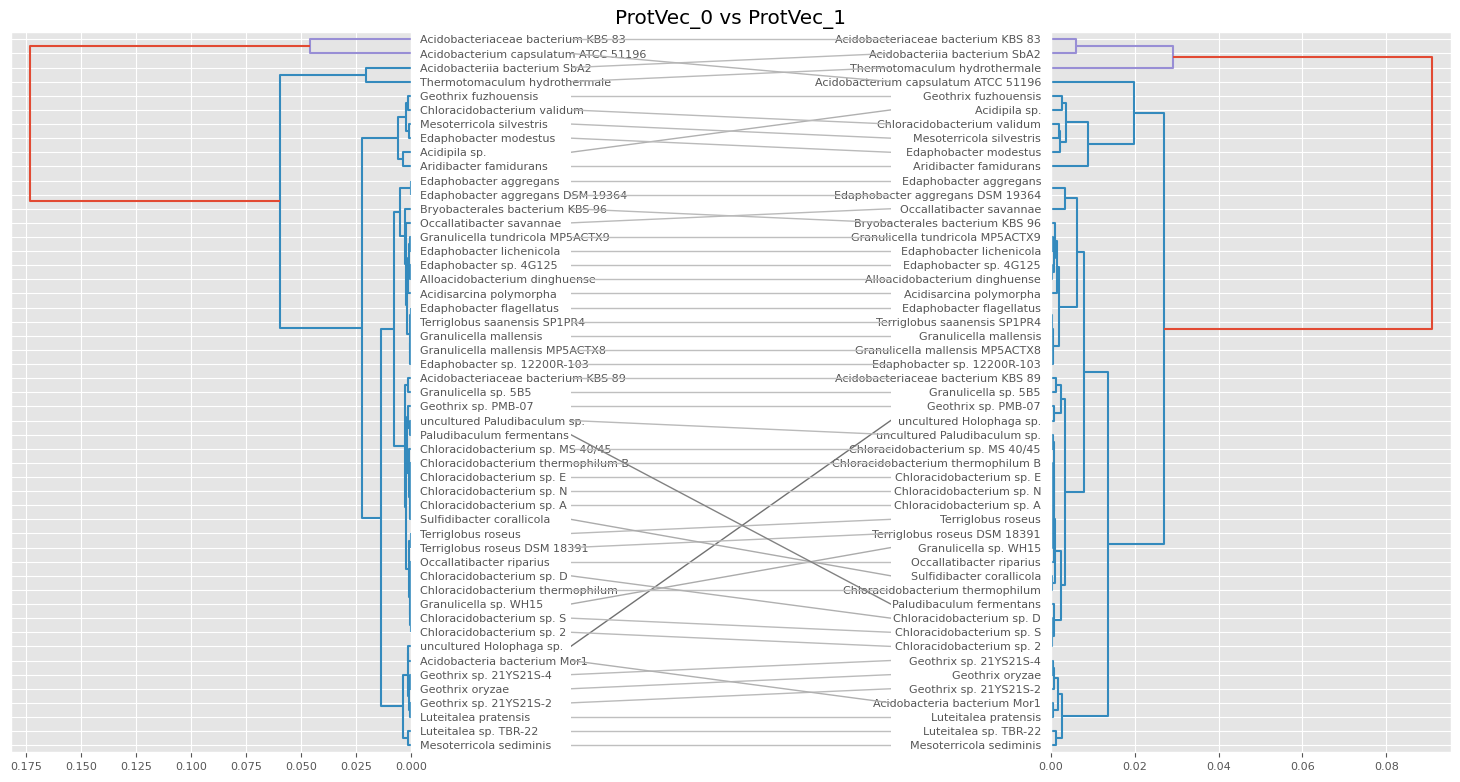

In [151]:
plot_tanglegram(linkage_0,linkage_1,df.index,df.index,"ProtVec_0 vs ProtVec_1")

INFO  : Finished optimising at entanglement 0.06 (tanglegram.tangle)
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tanglegram.tangle)


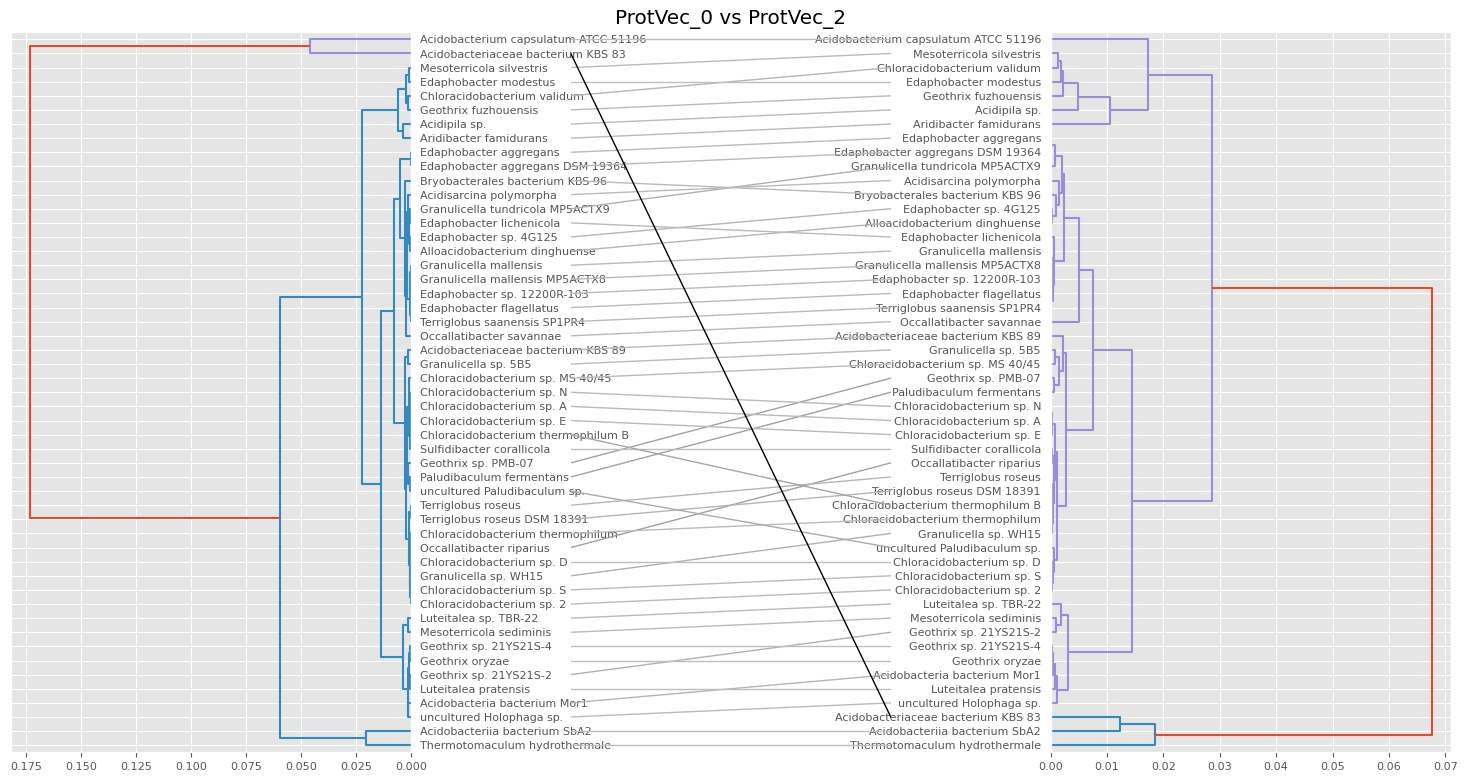

In [152]:
plot_tanglegram(linkage_0,linkage_2,df.index,df.index,"ProtVec_0 vs ProtVec_2")

INFO  : Finished optimising at entanglement 0.03 (tanglegram.tangle)
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tanglegram.tangle)


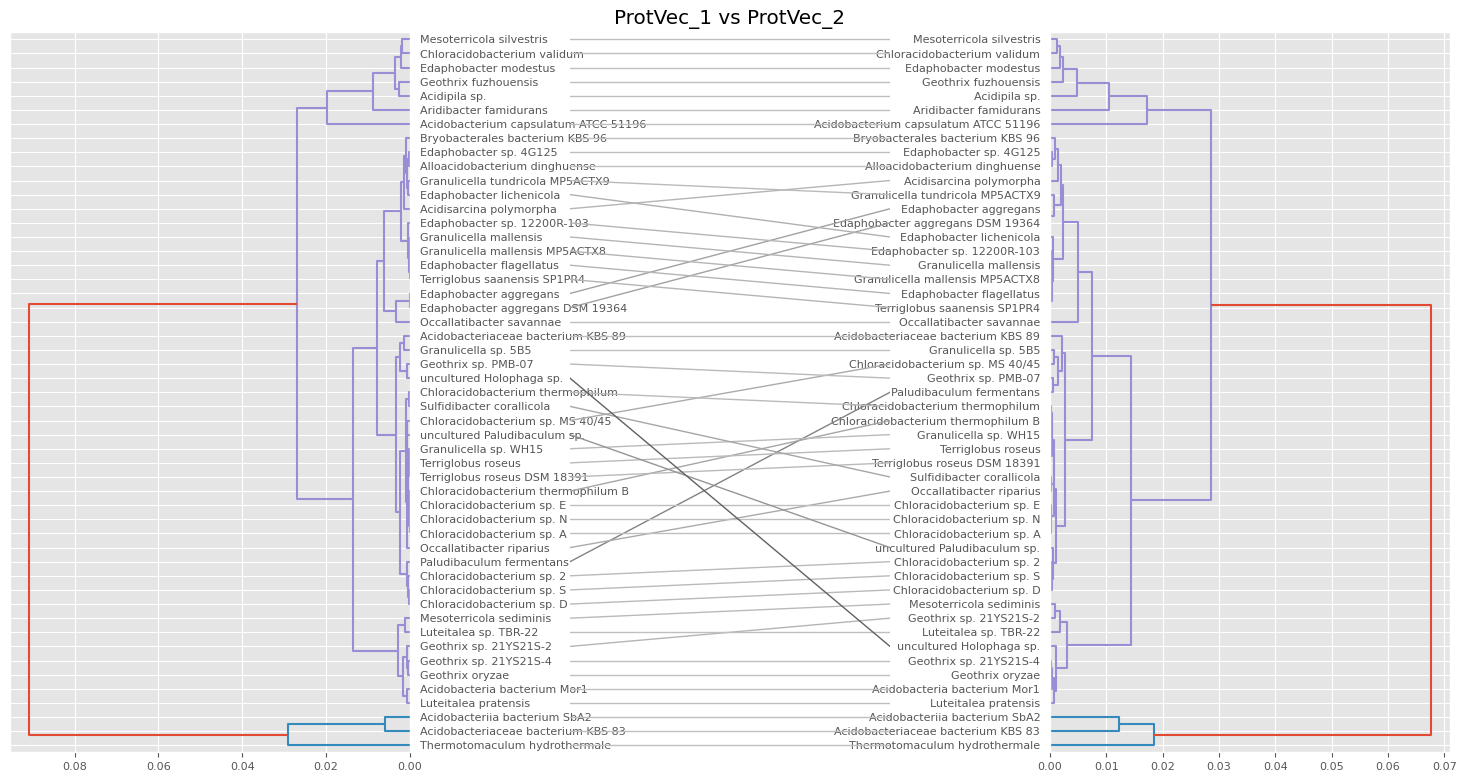

In [153]:
plot_tanglegram(linkage_1,linkage_2,df.index,df.index,"ProtVec_1 vs ProtVec_2")

INFO  : Finished optimising at entanglement 0.28 (tanglegram.tangle)
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tanglegram.tangle)


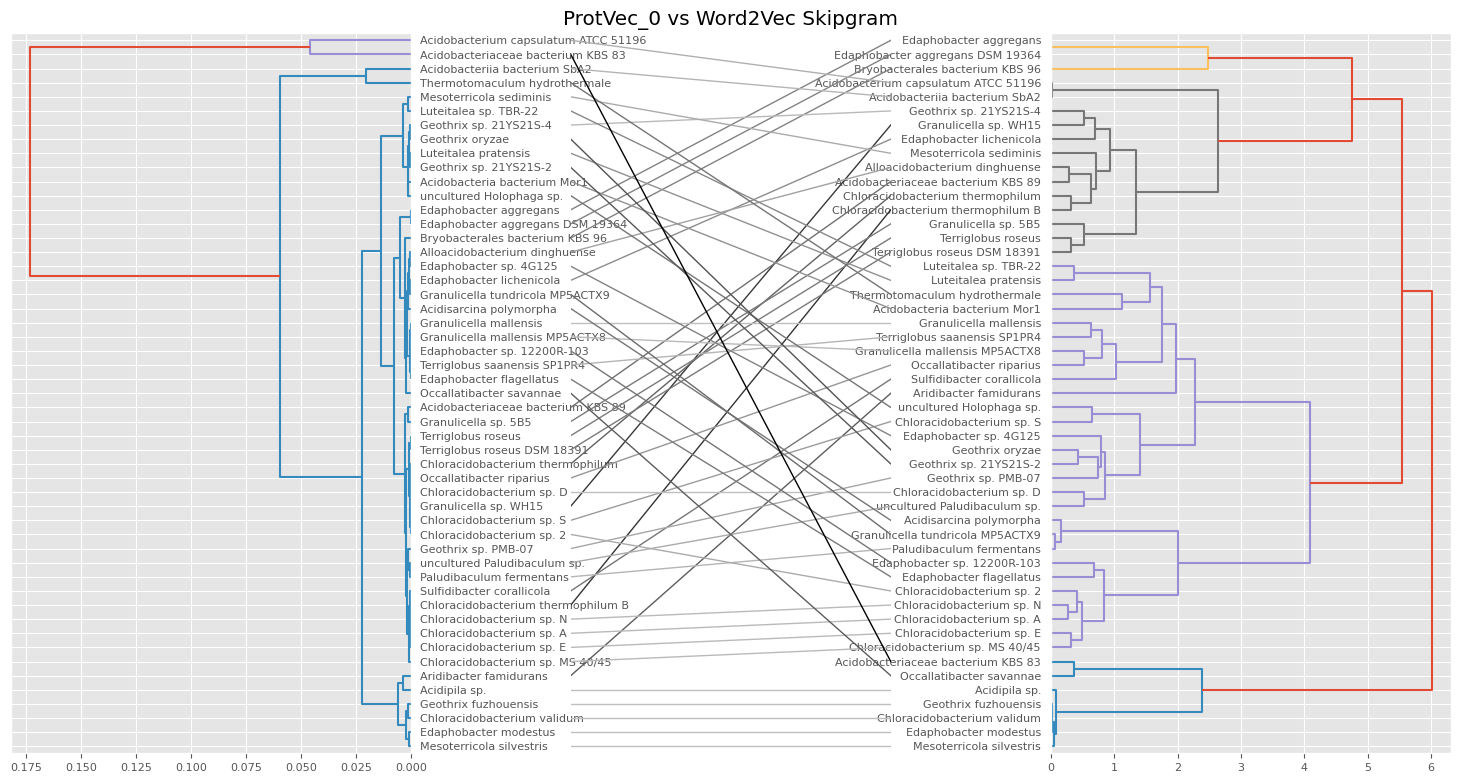

In [154]:
plot_tanglegram(linkage_0,linkage_skipgram,df.index,df.index,"ProtVec_0 vs Word2Vec Skipgram")

INFO  : Finished optimising at entanglement 0.19 (tanglegram.tangle)
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tanglegram.tangle)


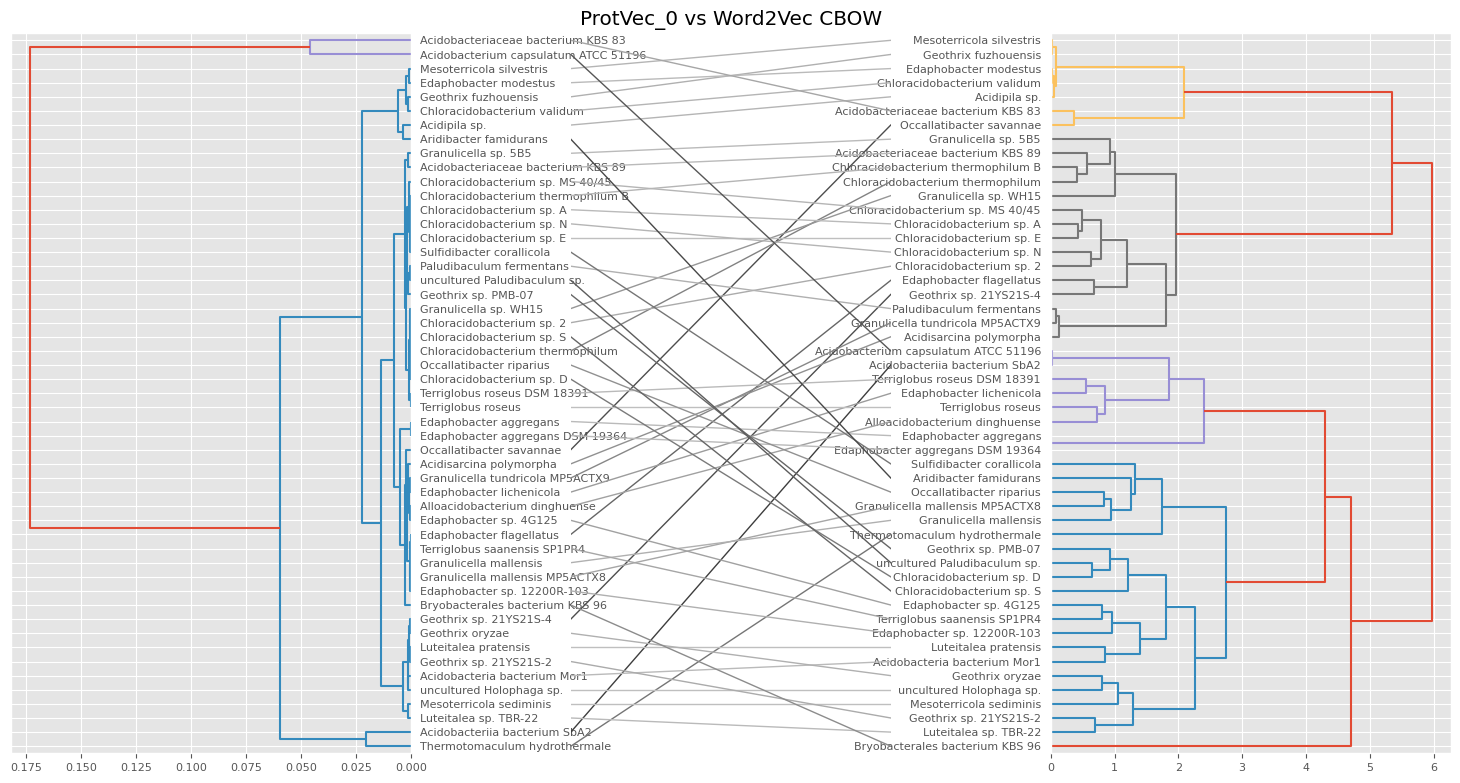

In [155]:
plot_tanglegram(linkage_0,linkage_cbow,df.index,df.index,"ProtVec_0 vs Word2Vec CBOW")